In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, periodogram

In [2]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (10, 6)
    }
)

In [ ]:
data_directory = '../Data/Cluster_Results/'

df_all = pd.read_csv(os.path.join(data_directory, 'all_clustered_results_cleaned.csv'))

# calculate and make some new columns
df_all['normalized_GFP'] = df_all['fluo2'] / df_all['fluo1']
df_all['time'] = df_all['frames']*0.25

# if  not os.path.exists(os.path.join(data_directory, "all_clustered_results.csv")):
#     df_all.to_csv(os.path.join(data_directory, "all_clustered_results.csv"), index=False)

# check columns
df_all.columns

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_78050/193266595.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(os.path.join(data_directory, 'all_clustered_results_cleaned.csv'))


Index(['Unnamed: 0', 'id', 'mother', 'frames', 'daughters', 'new_pole',
       'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1',
       'fluo2', 'x', 'y', 'IntDen', 'series', 'Autoinducer', 'gene', 'new_y',
       'new_x', 'Group', 'cluster', 'normalized_GFP', 'time'],
      dtype='object')

In [6]:
# define the variable for analysis
Autoinducer = 'Without'
Gene = 'lasI'
Fluo = 'fluo2'

df_test = df_all[(df_all['Autoinducer'] == Autoinducer) & (df_all['gene'] == Gene)].copy()

## Plot the distribution of intensity

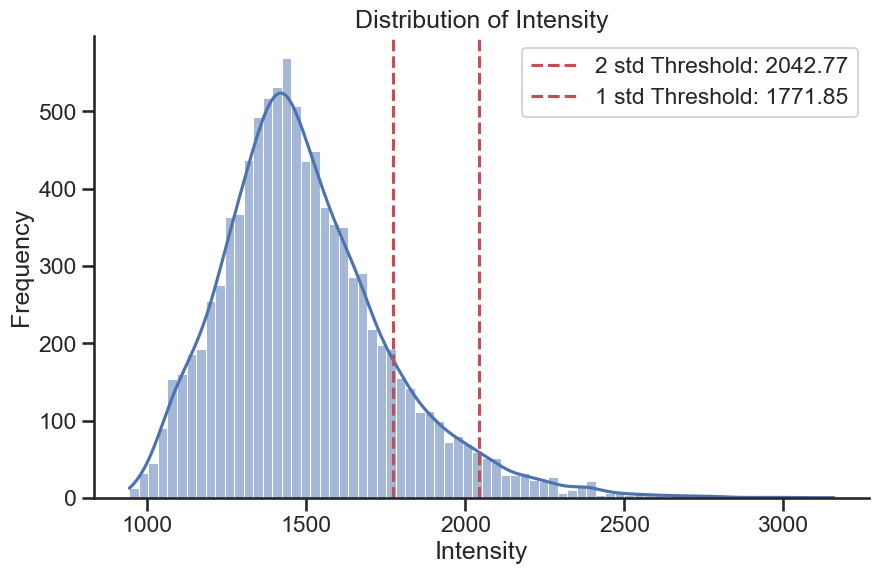

In [7]:
# define two threshold for the intensity
threshold_fluo = df_test[Fluo].abs().mean() + 2 * df_test[Fluo].abs().std()
threshold_fluo2 = df_test[Fluo].abs().mean() + 1 * df_test[Fluo].abs().std()

# plot the distribution plot of Rate
plt.figure(figsize=(10, 6))
sns.histplot(df_test[Fluo].dropna(), kde=True)
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity')
plt.axvline(threshold_fluo, color='r', linestyle='--', label=f'2 std Threshold: {threshold_fluo:.2f}')
plt.axvline(threshold_fluo2, color='r', linestyle='--', label=f'1 std Threshold: {threshold_fluo2:.2f}')
plt.legend()
plt.show()

# df_test['Hotspot_Fluo2'] = df_test['fluo2'].abs() > threshold_fluo2

In [8]:
# sort the df_test
df_test.sort_values(by=['cluster','id'], ascending=True, inplace=True)
df_test.reset_index(inplace=True, drop=True)

# calculate the first frame and relative time for each cell
df_test['first_frame'] = df_test.groupby(['cluster','id'])['frames'].transform('min')
df_test['relative_time'] = (df_test['frames'] - df_test['first_frame']) * 0.25

## plot for colony (average and each cell)

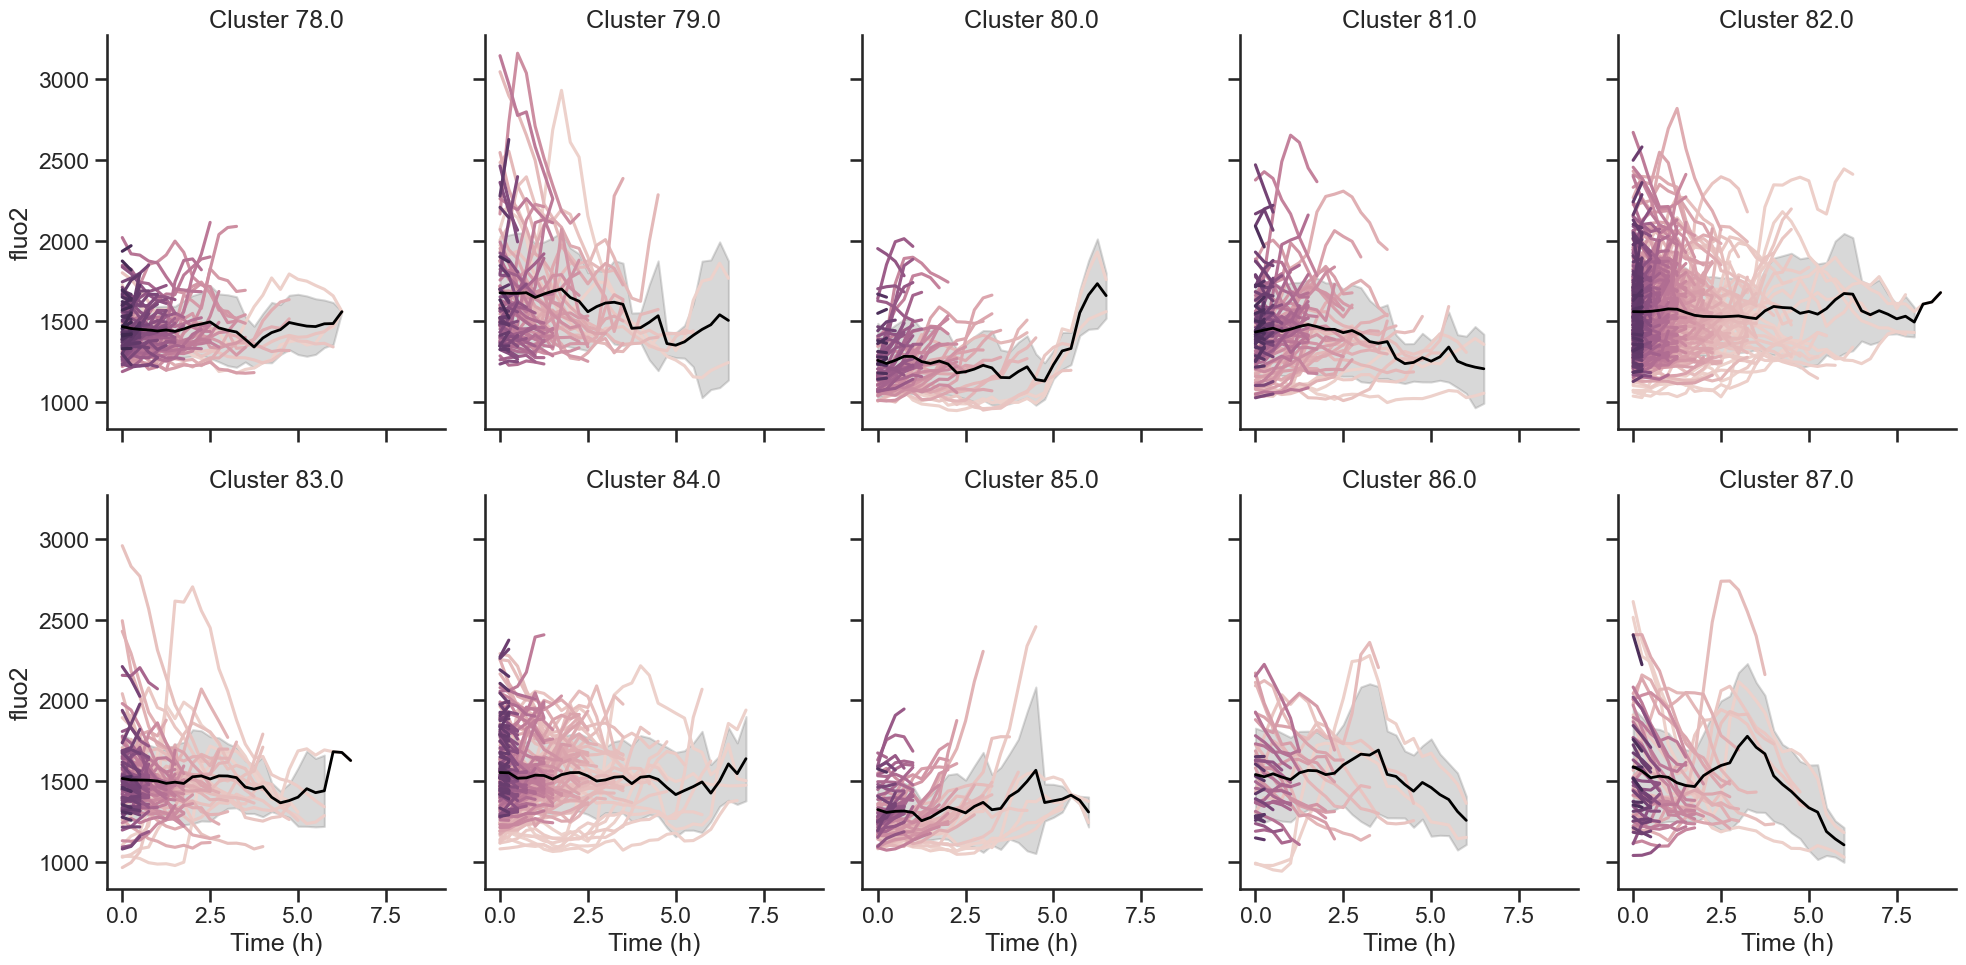

In [9]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(df_test.cluster.unique()) / 2)), figsize=(20, 10), sharey=True, sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate a color palette
#palette = sns.color_palette("husl", len(initial_cells.cluster.unique()))

count = 0
cl = df_test['cluster'].iloc[0]

# Plot fluo2 versus time for each initial cell with distinct colors and add mean/std lines
for ax, cluster in zip(axes, df_test['cluster'].unique()):
    if cluster != cl:
        count += 1
    
    df_cluster = df_test[df_test['cluster'] == cluster].copy()
    
    # Lineplot for individual cells
    sns.lineplot(data=df_cluster, x='relative_time', y=Fluo, ax=ax, hue='id', legend=False)
    
    # Calculate mean and std
    mean_values = df_cluster.groupby('relative_time')[Fluo].mean()
    std_values = df_cluster.groupby('relative_time')[Fluo].std()
    
    # Plot mean line
    ax.plot(mean_values.index, mean_values.values, color='black', label='Mean', linewidth=2)
    
    # Plot std shaded region
    ax.fill_between(mean_values.index,
                    mean_values.values - std_values.values,
                    mean_values.values + std_values.values,
                    color='gray', alpha=0.3, label='±STD')
    
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(Fluo)
    cl = cluster

# Remove any unused subplots
for ax in axes[len(df_test.cluster.unique()):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Mean Pulse Frequency: 0.02174647933317414
Mean Pulse Amplitude: 2275.993240529709


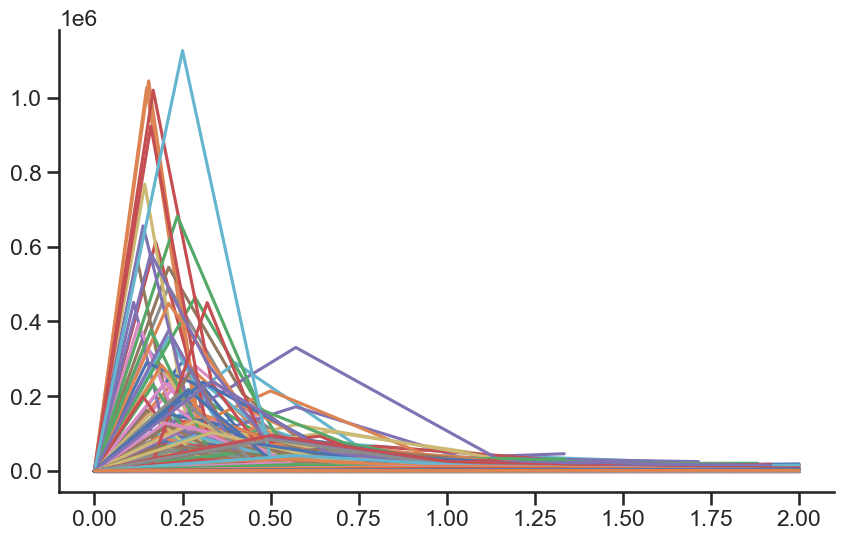

In [10]:
# plot the distribution plot of Rate and calculate the mean pulse frequency and amplitude

id_list = df_test[['cluster', 'id']].drop_duplicates().copy()

pulse_frequencies = []
pulse_amplitudes = []

for row in id_list.itertuples(index=False):
    cluster = row.cluster
    cell_id = row.id
    
    df_cell = df_test[(df_test['cluster'] == cluster) & (df_test['id'] == cell_id)].copy()
    time = df_cell['time'].values
    signal = df_cell[Fluo].values
    
    if len(time) < 2 or time[-1] == time[0] or np.isnan(time[-1] - time[0]):
        continue  # Skip if not enough time points or invalid time range
    
    # calculate the periodogram
    freqs, power = periodogram(signal, fs=1/0.25)
    plt.plot(freqs, power)
    
    # detect pulses
    peaks, properties = find_peaks(signal, height=threshold_fluo)
    pulse_frequency = len(peaks) / (time[-1] - time[0])  # pulse frequency
    pulse_frequencies.append(pulse_frequency)
    
    # Calculate pulse amplitudes
    amplitudes = properties['peak_heights']  # Amplitudes of detected peaks
    pulse_amplitudes.extend(amplitudes) 

mean_pulse_frequency = np.mean(pulse_frequencies)
print(f'Mean Pulse Frequency: {mean_pulse_frequency}')
    
# Calculate mean pulse amplitude
mean_pulse_amplitude = np.mean(pulse_amplitudes)
print(f'Mean Pulse Amplitude: {mean_pulse_amplitude}')

## plot for single cell

In [11]:
# Find the cell id at time 0 for each cluster
initial_cells = (df_test[df_test['frames'] == 0][['cluster', 'id']]
                 .sort_values(by=['cluster', 'id'])
                 .reset_index(drop=True))

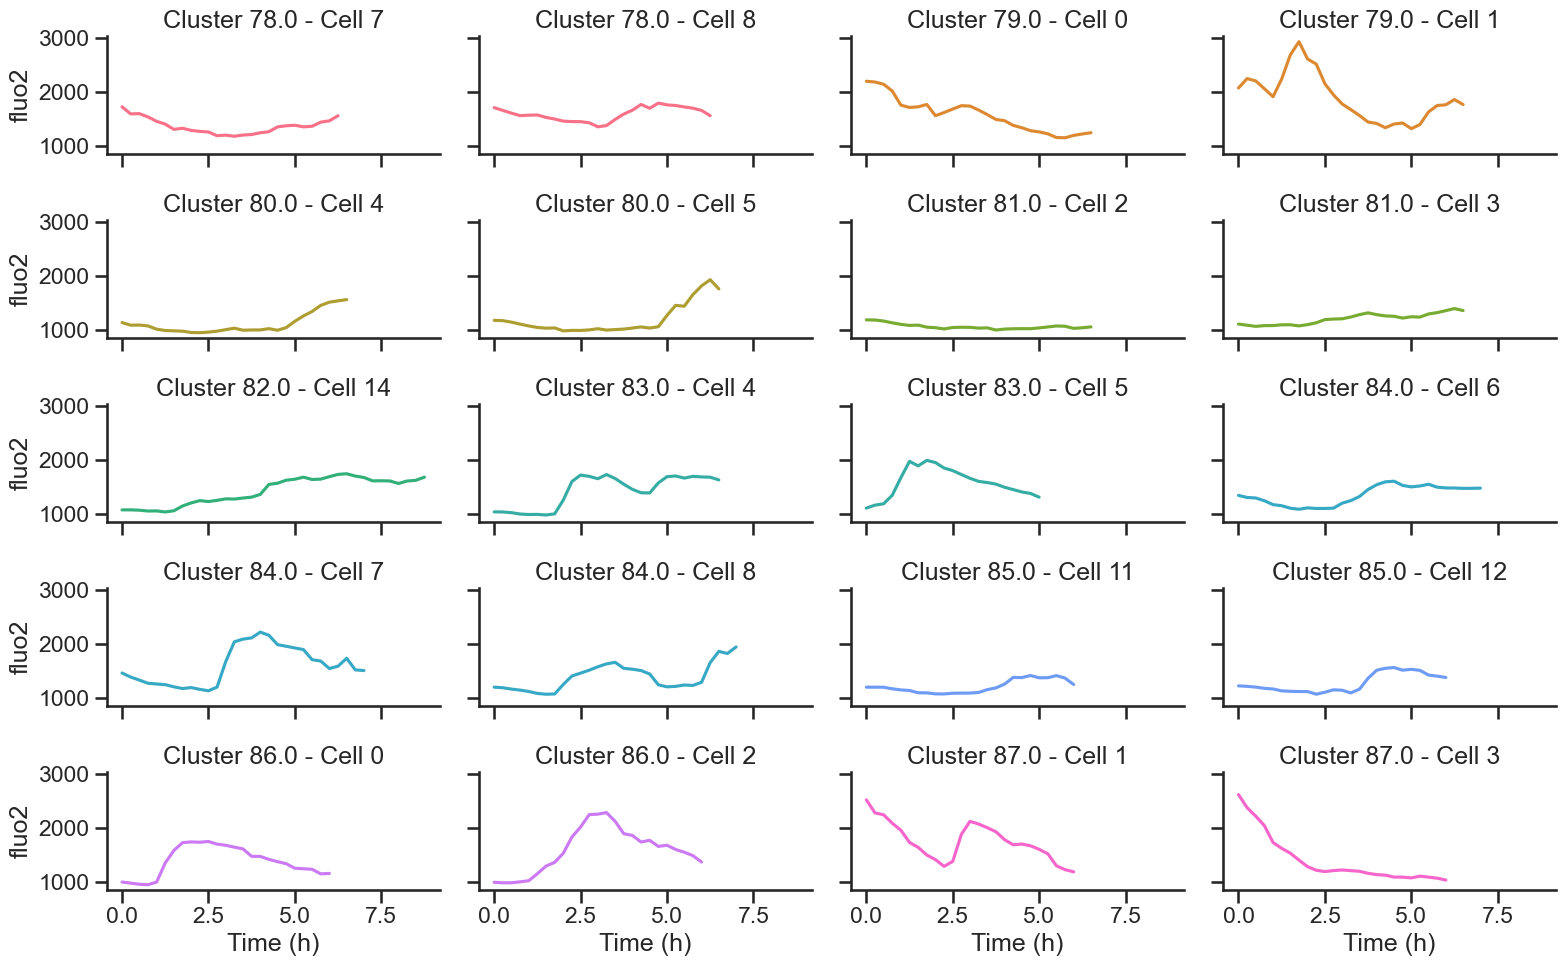

In [12]:
# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=int(np.ceil(len(initial_cells) / 5)), figsize=(16, 10), sharey=True, sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate a color palette
palette = sns.color_palette("husl", len(initial_cells.cluster.unique()))

count = 0
cl = initial_cells['cluster'].iloc[0]
# Plot fluo2 versus time for each initial cell with distinct colors
for ax, (cluster, cell_id) in zip(axes, initial_cells.itertuples(index=False)):
    if cluster != cl:
        count += 1
    df_cell = df_test[(df_test['cluster'] == cluster) & (df_test['id'] == cell_id)]
    sns.lineplot(data=df_cell, x='time', y=Fluo, ax=ax, color=palette[count])
    ax.set_title(f'Cluster {cluster} - Cell {cell_id}')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(Fluo)
    cl = cluster

# Remove any unused subplots
for ax in axes[len(initial_cells):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Mean Pulse Frequency: 0.039194139194139194
Mean Pulse Amplitude: 2356.776349761777


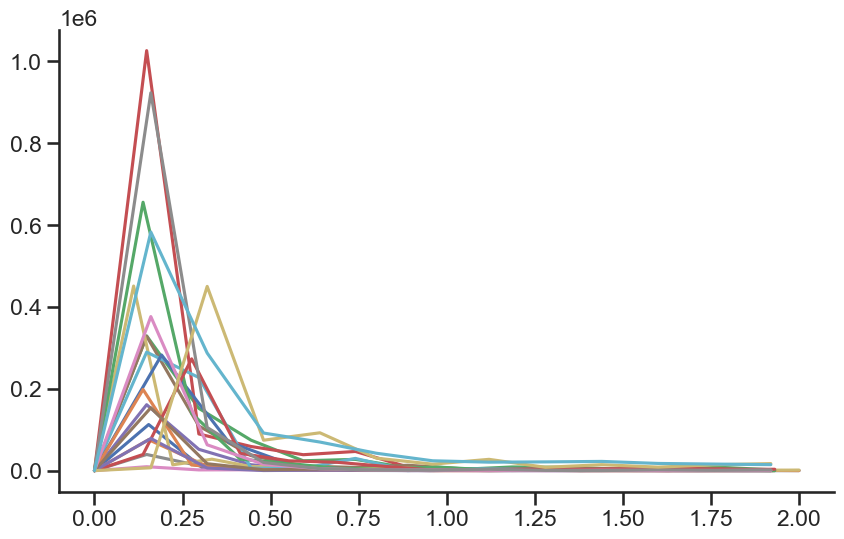

In [13]:
## check the pulse frequency distribution and mean values

pulse_frequencies = []
pulse_amplitudes = []

for cluster, cell_id in initial_cells.itertuples(index=False):
    df_cell = df_test[(df_test['cluster'] == cluster) & (df_test['id'] == cell_id)]
    time = df_cell['time'].values
    signal = df_cell[Fluo].values
    
    # calculate the periodogram
    freqs, power = periodogram(signal, fs=1/0.25)
    plt.plot(freqs, power)
    
    # detect pulses
    peaks, properties = find_peaks(signal, height=threshold_fluo)
    pulse_frequency = len(peaks) / (time[-1] - time[0])  # pulse frequency
    pulse_frequencies.append(pulse_frequency)
    
    # Calculate pulse amplitudes
    amplitudes = properties['peak_heights']  # Amplitudes of detected peaks
    pulse_amplitudes.extend(amplitudes) 

mean_pulse_frequency = np.mean(pulse_frequencies)
print(f'Mean Pulse Frequency: {mean_pulse_frequency}')
    
# Calculate mean pulse amplitude
mean_pulse_amplitude = np.mean(pulse_amplitudes)
print(f'Mean Pulse Amplitude: {mean_pulse_amplitude}')